## Output data preparation for dataset Twitch
#### Plots and figures in separate notebook

In [1]:
# IMPORTS
import matplotlib.pyplot as plt
import numpy as np
import csv 
import networkx as nx
from random import sample
import time
import math
import random
import scipy
import pandas as pd

In [2]:
# Define necessary functions

def arccosh_og(x):  ##note that x*x-1 might be less than zero :( And then log(t) could be negative (negative distance?!?!?!?!)
    t = x + math.sqrt(x * x - 1)
    return math.log(t)

def arccosh(x):
    t = x + math.sqrt(max(x * x, 1) - 1)
    return max(math.log(t), 0.5)
    
def query(coordinates, source, destination, curvature):
    
    if source == destination:
        return 0
    
    sourceCoords = coordinates[source]
    destinationCoords = coordinates[destination]

    i = 0
    ts = 1.0
    td = 1.0
    tt = 1.0

    for i in range(len(sourceCoords)):
        ts += math.pow(sourceCoords[i], 2)
        td += math.pow(destinationCoords[i], 2)
        tt += (sourceCoords[i] * destinationCoords[i])
    #print(ts, td, tt)
    t = math.sqrt(ts * td) - tt
    #print('t:', t)
    return arccosh(t) * math.fabs(curvature)

def intersection_similarity(u,v):
    return len(set(u).intersection(set(v)))

def weighted_intersection_similarity(u,v, alpha):
    similarity = 0
    if len(u)==len(v):
        n = len(u)
        for i in range(n):
            if u[i] in v:
                j = v.index(u[i])
                similarity += (n-abs(i-j))**alpha
                
    else:
        print('not equal vector lengths')
        similarity = -1
        
    return similarity

In [3]:
# READ REAL NETWORK - Giant Cconnected Component

dataset = 'large_twitch_edges.csv'

data = pd.read_csv(dataset, header = 0, sep = ',') 
data = data[[data.columns[0], data.columns[1]]]
data.head()

graph = nx.from_pandas_edgelist(data, data.columns[0], data.columns[1])
Gcc = sorted(nx.connected_components(graph), key=len, reverse=True)
giant = graph.subgraph(Gcc[0])

In [4]:
# SPECIFY THESE INPUTS

output_file_name = 'twitch/out'
partitions = 1
curvature = -1
number_of_nodes = 168114

#######################


landFile = output_file_name + '.land'
coordFiles = [output_file_name + str(i) + '.coord' for i in range(partitions)]

coordinates = dict()
with open(landFile) as infile:
    for line in infile:
        linesplit = line.split()
        id = int(linesplit[0])
        coords = [float(c) for c in linesplit[1:]]
        coordinates[id] = coords

for coordFile in coordFiles:
    with open(coordFile) as infile:
        for line in infile:
            linesplit = line.split()
            id = int(linesplit[0])
            coords = [float(c) for c in linesplit[1:]]
            coordinates[id] = coords

#while True:
#    query_input = input("Enter ID of 2 nodes: ")
        
#    if query_input == 'exit' or query_input == 'q' or query_input == 'quit':
       # break

#    querysplit = query_input.split()
#    source = int(querysplit[0])
#    destination = int(querysplit[1])

#    estimate = query(coordinates, source, destination, curvature)
#    print('Rigel estimates the distance between %d and %d to be %f.\n' % (source, destination, estimate))


In [42]:
# Relative errors - approximation: select 'select_count = 1000'  nodes from where distances (to all nodes) are calculated
### This is necessary due to slow EXACT path calculation

result_avg_path_length_estimated = []
result_avg_path_length_exact = []
result_radius_estimated = []
result_radius_exact = []
result_diameter_estimated = []
result_diameter_exact = []
top_cent_exact = []
top_cent_estimate = []
top_ecc_exact = []
top_ecc_estimate = []


for sed in range(5):
    print('START OF SEED', sed, '.')
    np.random.seed(sed)

    select_count = 1000
    selected_nodes = random.sample(range(number_of_nodes), select_count)

    relative_errors = dict()
    exact_distances = dict()
    estimated_distances= dict()

    avg_path_length_exact = 0
    avg_path_length_estimated = 0
    radius_estimated = number_of_nodes
    diameter_estimated = 0
    radius_exact = number_of_nodes
    diameter_exact = 0
    eccentricites_estimated = []
    eccentricites_exact  =[]
    centralities_exact = []
    centralities_estimated = []


    node_names = list(giant.nodes())

    iters = 0

    for source in selected_nodes:
        iters += 1
        if iters % int(select_count/10) == 0:
            print('Processed ', 10 * iters / int(select_count/10), '% of total calculations...')

        eccentricity_curr_est = 0
        eccentricity_curr_ex = 0
        exact_distances[source] = []
        estimated_distances[source] = []
        relative_errors[source] = []
        for target in selected_nodes:
            #print('points:', source, target)
            if source != target:
                estimate = query(coordinates, source, target, curvature)
                exact = nx.shortest_path_length(giant, node_names[source], node_names[target])
                avg_path_length_estimated += estimate
                avg_path_length_exact += exact
                eccentricity_curr_est = max(eccentricity_curr_est, estimate)
                diameter_estimated = max(diameter_estimated, estimate)
                eccentricity_curr_ex = max(eccentricity_curr_ex,exact)
                diameter_exact = max(diameter_exact,exact)
                relative_errors[source].append(abs(estimate-exact)/exact)
                exact_distances[source].append(exact)
                estimated_distances[source].append(estimate)
            else:
                relative_errors[source].append(0)
                exact_distances[source].append(0)
                estimated_distances[source].append(0)
        radius_estimated = min(eccentricity_curr_est, radius_estimated)
        radius_exact = min(eccentricity_curr_ex, radius_exact)
        eccentricites_estimated.append(0-eccentricity_curr_est)
        eccentricites_exact.append(0-eccentricity_curr_ex)
        centralities_exact.append(0-np.mean(list(exact_distances.values())))
        centralities_estimated.append(0-np.mean(list(estimated_distances.values())))

    avg_path_length_estimated = avg_path_length_estimated / (select_count * (select_count - 1) )
    avg_path_length_exact = avg_path_length_exact / (select_count * (select_count - 1) )
    
    result_avg_path_length_estimated.append(avg_path_length_estimated)
    result_avg_path_length_exact.append(avg_path_length_exact)
    result_radius_estimated.append(radius_estimated)
    result_radius_exact.append(radius_exact)
    result_diameter_estimated.append(diameter_estimated)
    result_diameter_exact.append(diameter_exact)

    ind = np.argpartition(centralities_exact, -20)[-20:]
    top_cent_exact.append(ind[np.argsort(np.array(centralities_exact)[ind])])
    ind = np.argpartition(centralities_estimated, -20)[-20:]
    top_cent_estimate.append(ind[np.argsort(np.array(centralities_estimated)[ind])])
    ind = np.argpartition(eccentricites_exact, -20)[-20:]
    top_ecc_exact.append(ind[np.argsort(np.array(eccentricites_exact)[ind])])
    ind = np.argpartition(eccentricites_estimated, -20)[-20:]
    top_ecc_estimate.append(ind[np.argsort(np.array(eccentricites_estimated)[ind])])

START OF SEED 0 .
Processed  10.0 % of total calculations...
Processed  20.0 % of total calculations...
Processed  30.0 % of total calculations...
Processed  40.0 % of total calculations...
Processed  50.0 % of total calculations...
Processed  60.0 % of total calculations...
Processed  70.0 % of total calculations...
Processed  80.0 % of total calculations...
Processed  90.0 % of total calculations...
Processed  100.0 % of total calculations...
START OF SEED 1 .
Processed  10.0 % of total calculations...
Processed  20.0 % of total calculations...
Processed  30.0 % of total calculations...
Processed  40.0 % of total calculations...
Processed  50.0 % of total calculations...
Processed  60.0 % of total calculations...
Processed  70.0 % of total calculations...
Processed  80.0 % of total calculations...
Processed  90.0 % of total calculations...
Processed  100.0 % of total calculations...
START OF SEED 2 .
Processed  10.0 % of total calculations...
Processed  20.0 % of total calculations..

In [43]:
# estimated metrics
print(result_avg_path_length_estimated)
print(result_avg_path_length_exact)
print(result_radius_estimated)
print(result_radius_exact)
print(result_diameter_estimated)
print(result_diameter_exact)

[2.6978105188833235, 2.7421731004825065, 2.7006032055157183, 2.659601815194189, 2.7258355169842963]
[2.8695275275275276, 2.900792792792793, 2.8918318318318317, 2.8433733733733733, 2.894818818818819]
[3.6907110781397536, 3.6341833100388046, 3.634298811026348, 3.6195945158198266, 3.8630546872697606]
[4, 4, 4, 4, 4]
[6.325781820205195, 6.275383422143065, 5.846624383127703, 5.90408804612268, 6.8185055093935185]
[6, 6, 6, 6, 6]


In [45]:
# Similarity of top central nodes
for i in range(5):
    print('Weighted Centrality similarity of top 20: ', weighted_intersection_similarity(list(top_cent_estimate[i]),list(top_cent_exact[i]),1))
    print('Weighted Eccentricity similarity of top 20: ', weighted_intersection_similarity(list(top_ecc_estimate[i]),list(top_ecc_exact[i]),1))
    print('Centrality similarity of top 20: ', intersection_similarity(list(top_cent_estimate[i]),list(top_cent_exact[i])))
    print('Eccentricity similarity of top 20: ', intersection_similarity(list(top_ecc_estimate[i]),list(top_ecc_exact[i])))

Weighted Centrality similarity of top 20:  270
Weighted Eccentricity similarity of top 20:  0
Centrality similarity of top 20:  17
Eccentricity similarity of top 20:  0
Weighted Centrality similarity of top 20:  261
Weighted Eccentricity similarity of top 20:  34
Centrality similarity of top 20:  15
Eccentricity similarity of top 20:  2
Weighted Centrality similarity of top 20:  366
Weighted Eccentricity similarity of top 20:  0
Centrality similarity of top 20:  19
Eccentricity similarity of top 20:  0
Weighted Centrality similarity of top 20:  255
Weighted Eccentricity similarity of top 20:  36
Centrality similarity of top 20:  16
Eccentricity similarity of top 20:  2
Weighted Centrality similarity of top 20:  274
Weighted Eccentricity similarity of top 20:  27
Centrality similarity of top 20:  15
Eccentricity similarity of top 20:  2


In [17]:
#save data for later reuse (plotting)
with open('twitch_diam_ex.pickle', 'wb') as handle:
    pickle.dump(result_diameter_exact, handle)

In [10]:
#Average relative error calculation
ARE_per_source = [np.mean(relative_errors[node]) for node in relative_errors.keys()]
ARE_total = np.mean(ARE_per_source)
print('Relative error (approximated): ', ARE_total)

Relative error (approximated):  0.15914362195131065


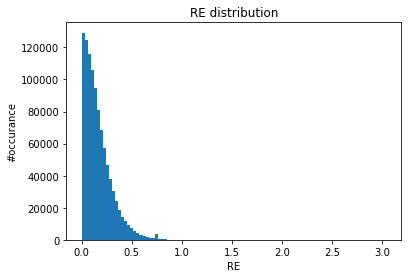

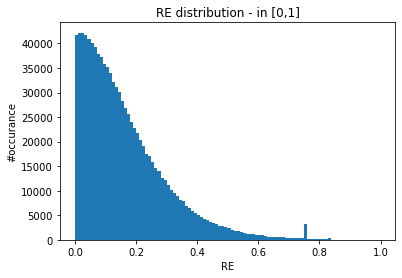

In [34]:
# distribution of relative error in total

relative_errors_total = []
for source in relative_errors.keys():
    relative_errors_total += relative_errors[source]
    #print(source, ': ' ,min(relative_errors[source]))

plt.hist(relative_errors_total, bins = 100)
plt.title('RE distribution')
plt.xlabel('RE')
plt.ylabel('#occurance')
plt.show()

plt.hist([relative_errors_total[i] for i in range(len(relative_errors_total)) if (relative_errors_total[i] < 1.0 and relative_errors_total[i] > 0.0)], bins = 100)
plt.title('RE distribution - in [0,1]')
plt.xlabel('RE')
plt.ylabel('#occurance')
plt.show()

In [36]:
# Save data for later reuse (plotting)
with open('twitch_erdist.pickle', 'wb') as handle:
    pickle.dump([relative_errors_total[i] for i in range(len(relative_errors_total)) if (relative_errors_total[i] < 1.0 and relative_errors_total[i] > 0.0)], handle)

with open('twitch_cdf.pickle', 'wb') as handle:
    pickle.dump({'bins': bins_count[1:], 'cdf':cdf }, handle)

In [ ]:
# Cumulative Distribution Function of the Distribution if Relative Errors

base = [relative_errors_total[i] for i in range(len(relative_errors_total)) if (relative_errors_total[i] < 1.0 and relative_errors_total[i] > 0.0)]
count, bins_count = np.histogram(base, bins=1000)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], cdf, label="CDF")
plt.title('CDF of Relative Error')
plt.xlabel('Relative Error')
plt.ylabel('CDF')
plt.show()